In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import mne
from scipy.stats import linregress, spearmanr

import mni_utils as uti
from mni_plots import plot_corr_tau_sc

### Paths and names

In [4]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
tau_dir = "Results"
tau_gamma_dir = "Results_gamma"
tau_path = data_path.joinpath(tau_dir)
tau_gamma_path = data_path.joinpath(tau_gamma_dir)

### 1) Timescales for all electrodes:

In [34]:
# Dataframe with timescales for all electrodes
df_tau = (
    pd.read_csv(tau_path.joinpath("all_tau.csv"), index_col=0)
    .dropna()
    .reset_index(drop=True)
)

# Dataframes of gamma timescales
df_tau_fast = (
    pd.read_csv(tau_gamma_path.joinpath("all_knee.csv"), index_col=0)
    .dropna()
    .reset_index(drop=True)
)
df_tau_slow = (
    pd.read_csv(tau_gamma_path.joinpath("all_tau.csv"), index_col=0)
    .dropna()
    .reset_index(drop=True)
)

For all stages:

Linregress results: r = -0.03576552064893607, p = 0.006825403337204424
Spearman results: r = -0.014431225855348407, p = 0.2751577322200013
Linregress results: r = 0.3763019708002938, p = 7.270953838061858e-192
Spearman results: r = 0.3537348268613101, p = 3.111728889031587e-168


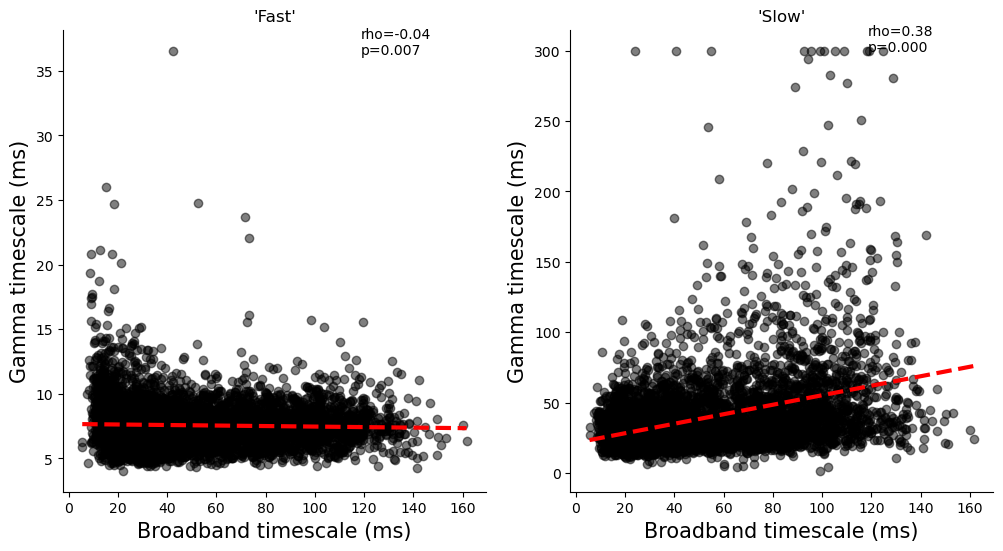

In [60]:
fig, axs = plt.subplots(1, 2, figsize=[12, 6])

axs[0] = plot_corr_tau_sc(
    axs[0], df_tau["tau"], df_tau_fast["tau"], color_line="r", title="'Fast'"
)
axs[0].set_xlabel("Broadband timescale (ms)")
axs[0].set_ylabel("Gamma timescale (ms)")
axs[1] = plot_corr_tau_sc(
    axs[1], df_tau["tau"], df_tau_slow["tau"], color_line="r", title="'Slow'"
)
axs[1].set_xlabel("Broadband timescale (ms)")
axs[1].set_ylabel("Gamma timescale (ms)")

plt.show()

Separated by stage:

W
Linregress results: r = -0.14760144856265883, p = 4.2886825002284373e-10
Spearman results: r = -0.17434584405583786, p = 1.4616427733466866e-13
Linregress results: r = -0.0450626390810271, p = 0.05788834192128183
Spearman results: r = -0.17921098736031532, p = 2.9568676693758446e-14


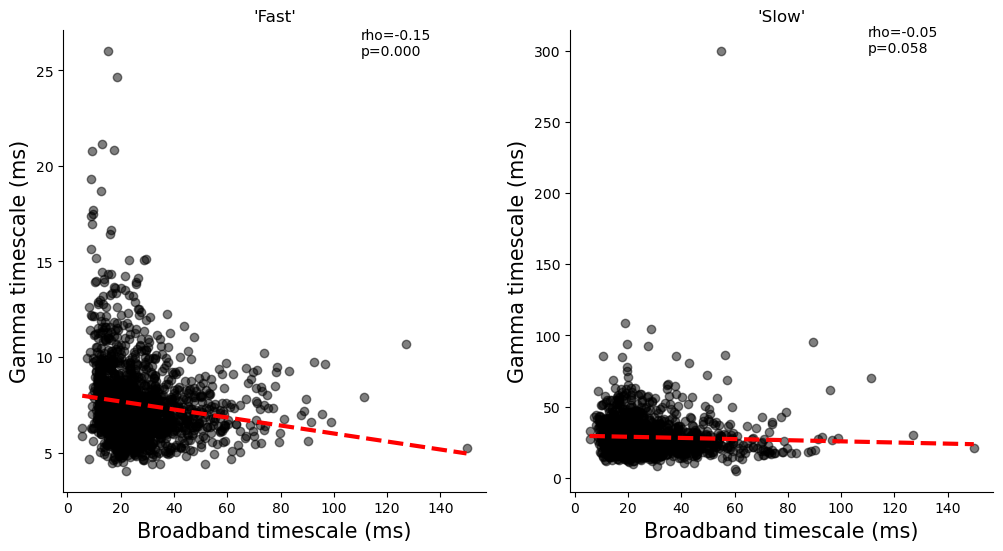

N3
Linregress results: r = -0.03666949409528826, p = 0.16024490488625082
Spearman results: r = -0.02212939201755246, p = 0.3968514275299415
Linregress results: r = 0.1663474660760583, p = 1.4285414281496905e-10
Spearman results: r = 0.17439107237195184, p = 1.7245142600158983e-11


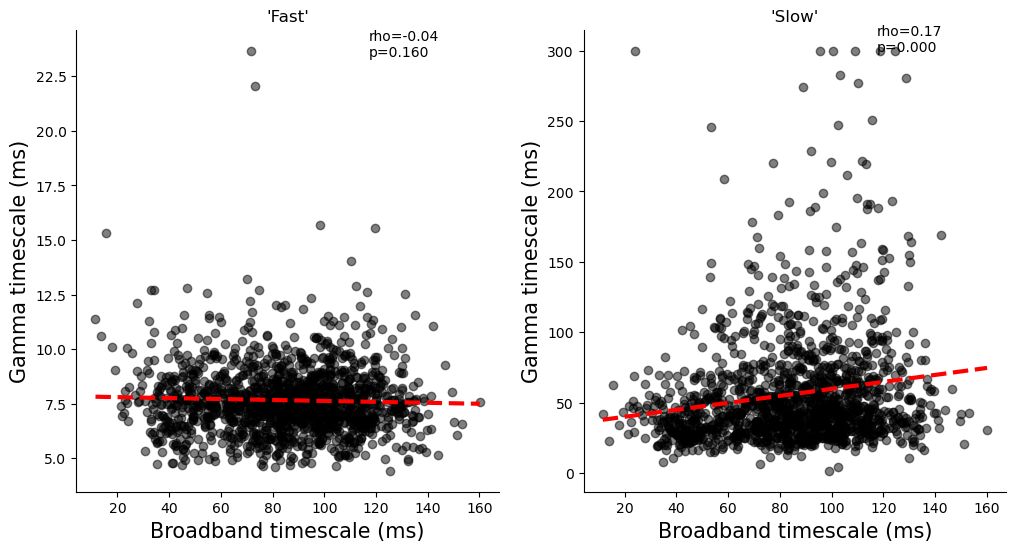

R
Linregress results: r = -0.16967271804133358, p = 5.623769483179694e-08
Spearman results: r = -0.23077656687942683, p = 1.0621380628525452e-13
Linregress results: r = 0.12498312092719892, p = 6.700309335991048e-05
Spearman results: r = 0.02264985236147254, p = 0.4716864804394947


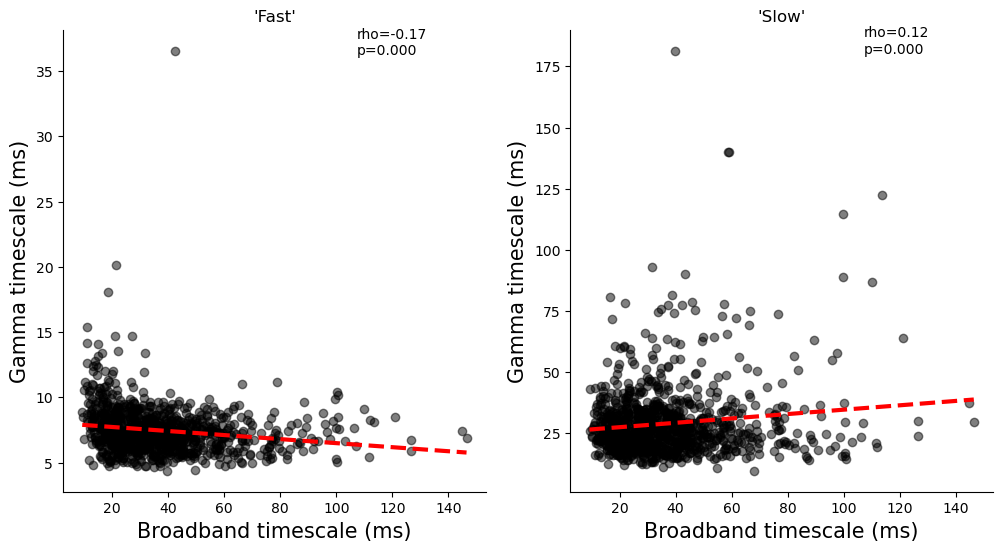

In [62]:
for stage in ["W", "N3", "R"]:

    df_tau_stage = df_tau[df_tau["stage"] == stage]
    df_tau_fast_stage = df_tau_fast[df_tau_fast["stage"] == stage]
    df_tau_slow_stage = df_tau_slow[df_tau_slow["stage"] == stage]

    print(stage)
    fig, axs = plt.subplots(1, 2, figsize=[12, 6])
    axs[0] = plot_corr_tau_sc(
        axs[0],
        df_tau_stage["tau"],
        df_tau_fast_stage["tau"],
        color_line="r",
        title="'Fast'",
    )
    axs[0].set_xlabel("Broadband timescale (ms)")
    axs[0].set_ylabel("Gamma timescale (ms)")
    axs[1] = plot_corr_tau_sc(
        axs[1],
        df_tau_stage["tau"],
        df_tau_slow_stage["tau"],
        color_line="r",
        title="'Slow'",
    )
    axs[1].set_xlabel("Broadband timescale (ms)")
    axs[1].set_ylabel("Gamma timescale (ms)")

    plt.show()

### Robust or mixed-effects models

In [54]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [56]:
rlm_model = sm.RLM(
    df_tau["tau"].to_numpy(), sm.add_constant(df_tau_slow["tau"].to_numpy())
)
rlm_results = rlm_model.fit()

rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 5720
Model:                            RLM   Df Residuals:                     5718
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 01 Mar 2024                                         
Time:                        15:00:19                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2026      0.634     47.633      0.000      28.960      31.445
x1             0.4645      0.013     34.882      0.000       0.438       0.491
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [58]:
data = pd.DataFrame(
    {
        "pat": df_tau["pat"],
        "tau": df_tau["tau"],
        "tau_fast": df_tau_fast["tau"],
        "tau_slow": df_tau_slow["tau"],
    }
)

# Mixed model
md = smf.mixedlm("tau_slow ~ tau_fast", data, groups=data["pat"])
mdf = md.fit()

# Extract fitted model
mdf.summary()

Intercept    25.665471
tau_fast      1.677578
dtype: float64

Separated by stage:

W
Linregress results: r = -0.14760144856265883, p = 4.2886825002284373e-10
Speraman results: r = -0.17434584405583786, p = 1.4616427733466866e-13
Linregress results: r = -0.0450626390810271, p = 0.05788834192128183
Speraman results: r = -0.17921098736031532, p = 2.9568676693758446e-14


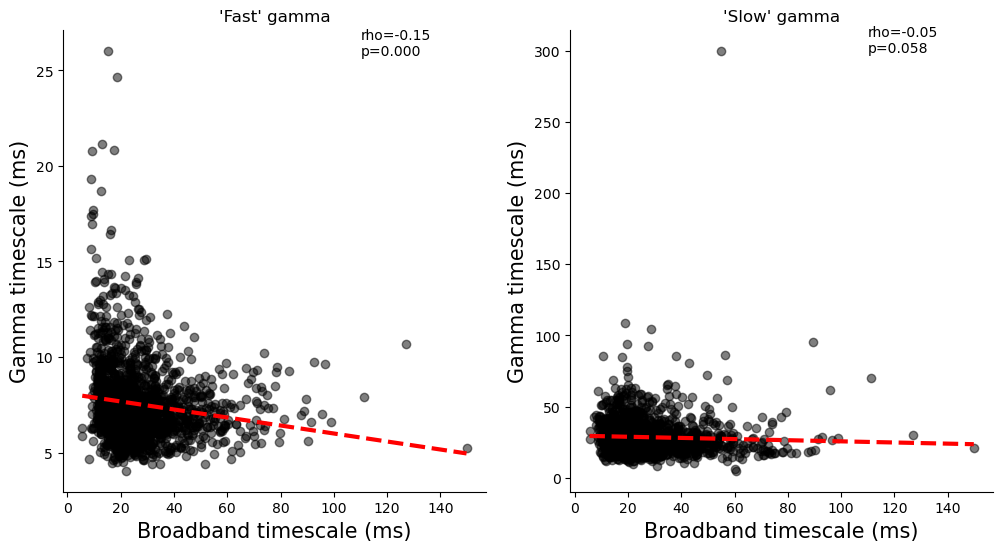

N3
Linregress results: r = -0.03666949409528826, p = 0.16024490488625082
Speraman results: r = -0.02212939201755246, p = 0.3968514275299415
Linregress results: r = 0.1663474660760583, p = 1.4285414281496905e-10
Speraman results: r = 0.17439107237195184, p = 1.7245142600158983e-11


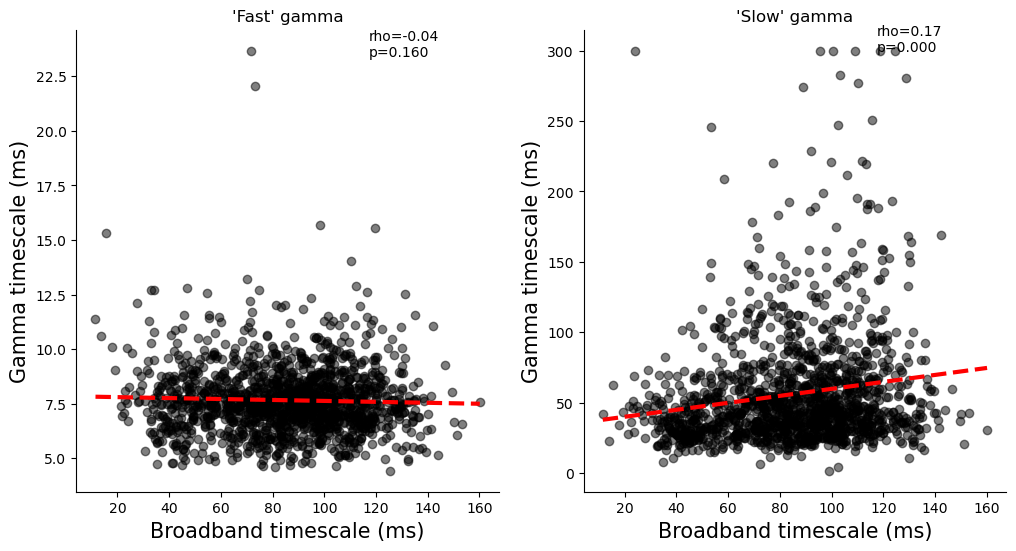

R
Linregress results: r = -0.16967271804133358, p = 5.623769483179694e-08
Speraman results: r = -0.23077656687942683, p = 1.0621380628525452e-13
Linregress results: r = 0.12498312092719892, p = 6.700309335991048e-05
Speraman results: r = 0.02264985236147254, p = 0.4716864804394947


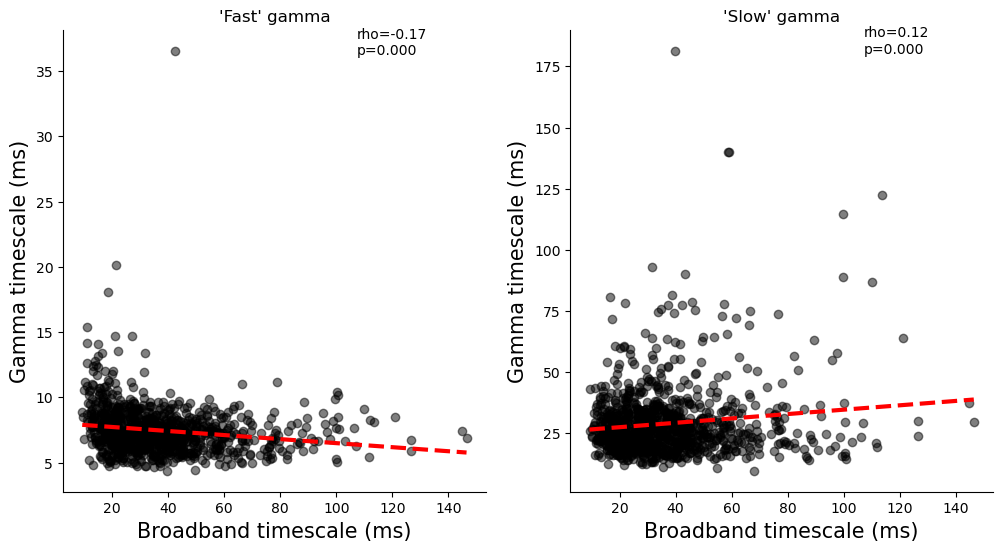

In [41]:
for stage in ["W", "N3", "R"]:

    df_tau_stage = df_tau[df_tau["stage"] == stage]
    df_tau_fast_stage = df_tau_fast[df_tau_fast["stage"] == stage]
    df_tau_slow_stage = df_tau_slow[df_tau_slow["stage"] == stage]

    print(stage)
    fig, axs = plt.subplots(1, 2, figsize=[12, 6])
    axs[0] = plot_corr_tau_sc(
        axs[0],
        df_tau_stage["tau"],
        df_tau_fast_stage["tau"],
        color_line="r",
        title="'Fast'",
    )
    axs[0].set_xlabel("Broadband timescale (ms)")
    axs[0].set_ylabel("Gamma timescale (ms)")
    axs[1] = plot_corr_tau_sc(
        axs[1],
        df_tau_stage["tau"],
        df_tau_slow_stage["tau"],
        color_line="r",
        title="'Slow'",
    )
    axs[1].set_xlabel("Broadband timescale (ms)")
    axs[1].set_ylabel("Gamma timescale (ms)")

    plt.show()

### 2) Parcellated:

In [42]:
# Dataframe with information on parcellated timescales values
df_tau_parc = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
df_tau_fast_parc = {
    stage: pd.read_csv(tau_gamma_path.joinpath(f"knee_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
df_tau_slow_parc = {
    stage: pd.read_csv(tau_gamma_path.joinpath(f"tau_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

W
Linregress results: r = -0.35319593974594543, p = 1.1546094635892794e-06
Spearman results: r = -0.3058468882784448, p = 2.97627791243549e-05
Linregress results: r = -0.08185249466309046, p = 0.27467934214644335
Spearman results: r = -0.11235326193195264, p = 0.13319157106029555


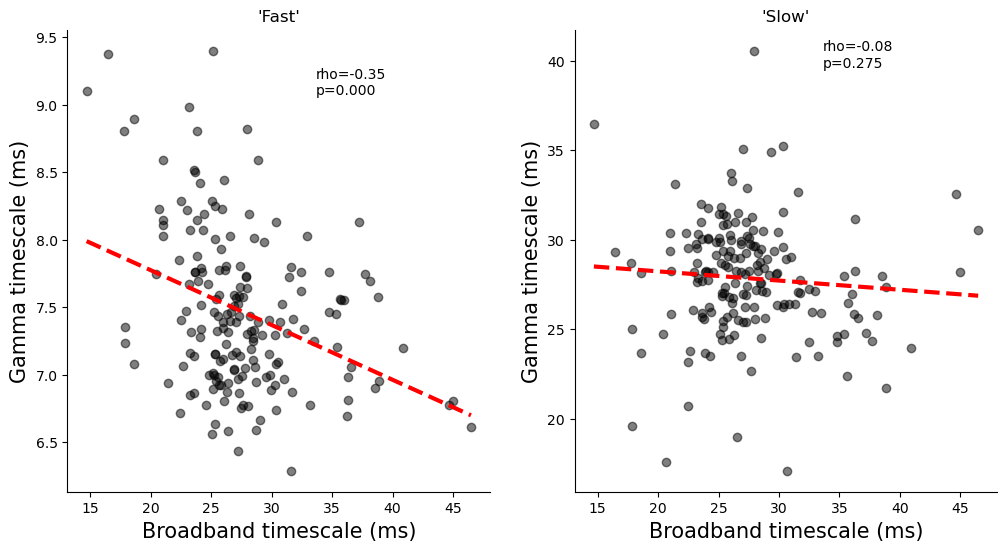

N3
Linregress results: r = 0.20648062619597232, p = 0.005419822197581766
Spearman results: r = 0.18115785466629628, p = 0.014944274799071957
Linregress results: r = -0.09963608816255573, p = 0.18326818294940606
Spearman results: r = -0.029348642447812177, p = 0.695727422076243


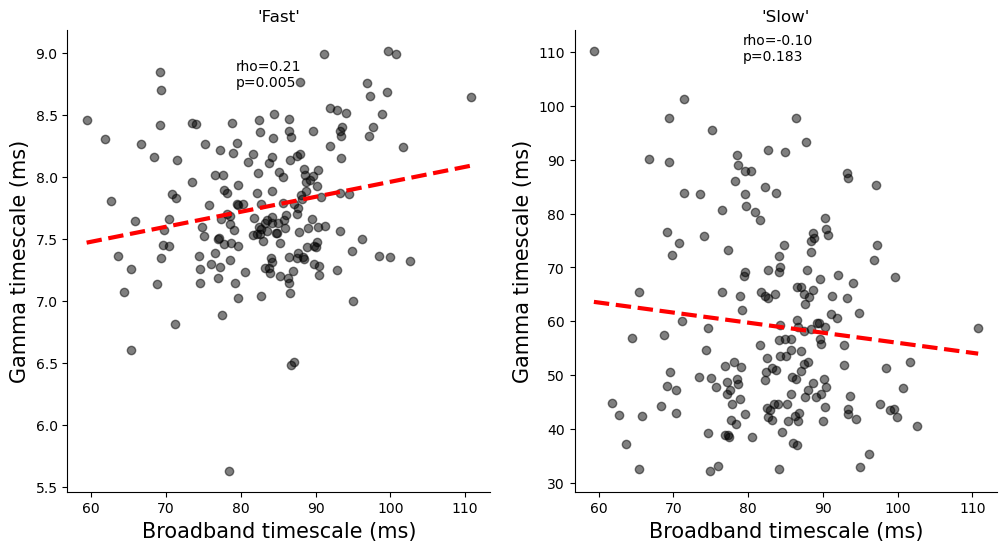

R
Linregress results: r = -0.3445810371392715, p = 2.1721529047138052e-06
Spearman results: r = -0.398166610080558, p = 3.106013264802589e-08
Linregress results: r = 0.214100614214167, p = 0.0039018294484180626
Spearman results: r = 0.09066740743027048, p = 0.22610582314183286


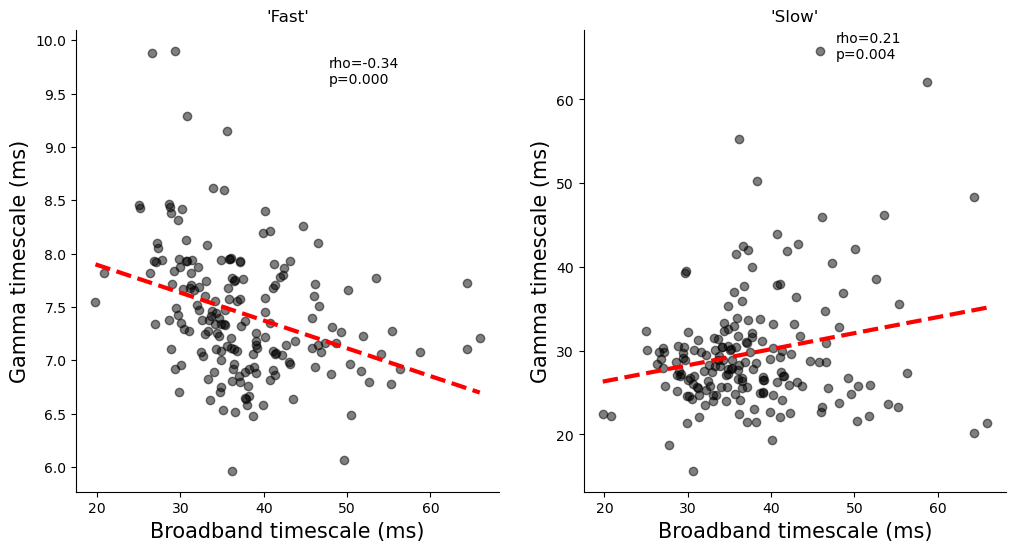

In [63]:
for stage in ["W", "N3", "R"]:

    print(stage)
    fig, axs = plt.subplots(1, 2, figsize=[12, 6])
    axs[0] = plot_corr_tau_sc(
        axs[0],
        df_tau_parc[stage],
        df_tau_fast_parc[stage],
        color_line="r",
        title="'Fast'",
    )
    axs[0].set_xlabel("Broadband timescale (ms)")
    axs[0].set_ylabel("Gamma timescale (ms)")
    axs[1] = plot_corr_tau_sc(
        axs[1],
        df_tau_parc[stage],
        df_tau_slow_parc[stage],
        color_line="r",
        title="'Slow'",
    )
    axs[1].set_xlabel("Broadband timescale (ms)")
    axs[1].set_ylabel("Gamma timescale (ms)")

    plt.show()